# Import libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set visual style for plots
sns.set(style="whitegrid")

function for downcasting, and we will need for optimization

In [2]:
def downcaste_dtype(df):
    previous_memory_consumption = (df.memory_usage().sum()) / 1024**2 
    for col in df.columns:
        col_dtype = df[col].dtypes
        if col_dtype != 'object':
            xmin = df[col].min()
            xmax = df[col].max()
            if str(col_dtype)[0] == 'i': 
                if np.iinfo('int8').min < xmin and np.iinfo('int8').max > xmax:
                    df[col] = df[col].astype('int8')
                elif np.iinfo('int16').min < xmin and np.iinfo('int16').max > xmax:
                    df[col] = df[col].astype('int16')
                elif np.iinfo('int32').min < xmin and np.iinfo('int32').max > xmax:
                    df[col] = df[col].astype('int32')
                elif np.iinfo('int64').min < xmin and np.iinfo('int64').max > xmax:
                    df[col] = df[col].astype('int64')
                    
            elif str(col_dtype)[0] == 'f': 
                if np.finfo('float16').min < xmin and np.finfo('float16').max > xmax:
                    df[col] = df[col].astype('float16')
                elif np.finfo('float32').min < xmin and np.finfo('float32').max > xmax:
                    df[col] = df[col].astype('float32')
                elif np.finfo('float64').min < xmin and np.finfo('float64').max > xmax:
                    df[col] = df[col].astype('float64')
            else:
                pass

    after_memory_consumption = (df.memory_usage().sum()) / 1024**2
    percentage_of_decrease = ((previous_memory_consumption - after_memory_consumption) / previous_memory_consumption) * 100

    print('Memory usage before downcasting: {:.2f} MB'.format(previous_memory_consumption))
    print('After Downcasting the memory usage decreased to: {:.2f} MB'.format(after_memory_consumption))
    print('Memory usage decreased by {:.3f}%'.format(percentage_of_decrease))

    return df

# Load datasets

In [3]:
pos_cash_loans = pd.read_csv('../DataSet/previous_pos_cash_loans.csv')
credit_cards = pd.read_csv('../DataSet/previous_credit_cards.csv')

In [4]:
# optimizing
pos_cash_loans = downcaste_dtype(pos_cash_loans)
credit_cards = downcaste_dtype(credit_cards)

Memory usage before downcasting: 610.43 MB
After Downcasting the memory usage decreased to: 238.45 MB
Memory usage decreased by 60.937%
Memory usage before downcasting: 673.88 MB
After Downcasting the memory usage decreased to: 289.33 MB
Memory usage decreased by 57.065%


# Merging datasets

In [5]:
merged_data = pd.merge(pos_cash_loans, credit_cards, on='sk_id_curr', how='inner')

# Data Cleaning and Preprocessing

In [6]:
# Checking for missing values
missing_values = merged_data.isnull().sum()

# handling missing values
merged_data['amt_balance'].fillna(merged_data['amt_balance'].median(), inplace=True)
merged_data['cnt_instalment'].fillna(merged_data['cnt_instalment'].mode()[0], inplace=True)

# Exploratory Data Analysis (EDA)

In [7]:
summary = merged_data.describe()
summary

,sk_id_prev_x,sk_id_curr,months_balance_x,cnt_instalment,cnt_instalment_future,sk_dpd_x,sk_dpd_def_x,sk_id_prev_y,months_balance_y,amt_balance,...,amt_receivable_principal,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,sk_dpd_y,sk_dpd_def_y
count,1.478211e+08,1.478211e+08,1.478211e+08,147821071.0,147608414.0,1.478211e+08,1.478211e+08,1.478211e+08,1.478211e+08,1.478211e+08,...,1.478211e+08,1.478211e+08,1.478211e+08,117916137.0,1.478211e+08,117916137.0,117916137.0,135623575.0,1.478211e+08,1.478211e+08
mean,1.906776e+06,2.781151e+05,-3.979594e+01,NaN,NaN,1.089750e+01,5.008139e-01,1.902859e+06,-3.471872e+01,6.105927e+04,...,5.860258e+04,6.086295e+04,6.087164e+04,NaN,6.357063e-01,NaN,NaN,NaN,5.605132e+00,3.914309e-01
std,5.373117e+05,1.025833e+05,2.776322e+01,0.0,0.0,1.254943e+02,2.804152e+01,5.370495e+05,2.630597e+01,1.074728e+05,...,1.036062e+05,1.071613e+05,1.071687e+05,0.0,2.884613e+00,0.0,0.0,0.0,7.392952e+01,2.366045e+01
min,1.000002e+06,1.000060e+05,-9.600000e+01,1.0,0.0,0.000000e+00,0.000000e+00,1.000018e+06,-9.600000e+01,-4.202502e+05,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00
25%,1.435305e+06,1.895460e+05,-6.300000e+01,10.0,3.0,0.000000e+00,0.000000e+00,1.430442e+06,-5.500000e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,4.0,0.000000e+00,0.000000e+00
50%,1.900189e+06,2.781180e+05,-3.300000e+01,12.0,8.0,0.000000e+00,0.000000e+00,1.894774e+06,-2.800000e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,16.0,0.000000e+00,0.000000e+00
75%,2.372106e+06,3.670630e+05,-1.600000e+01,24.0,17.0,0.000000e+00,0.000000e+00,2.369659e+06,-1.200000e+01,9.425232e+04,...,8.979016e+04,9.398030e+04,9.399227e+04,0.0,0.000000e+00,0.0,0.0,34.0,0.000000e+00,0.000000e+00
max,2.843490e+06,4.562500e+05,-1.000000e+00,81.0,72.0,4.231000e+03,3.595000e+03,2.843496e+06,-1.000000e+00,1.505902e+06,...,1.472317e+06,1.493338e+06,1.493338e+06,51.0,1.650000e+02,12.0,165.0,120.0,3.260000e+03,3.260000e+03


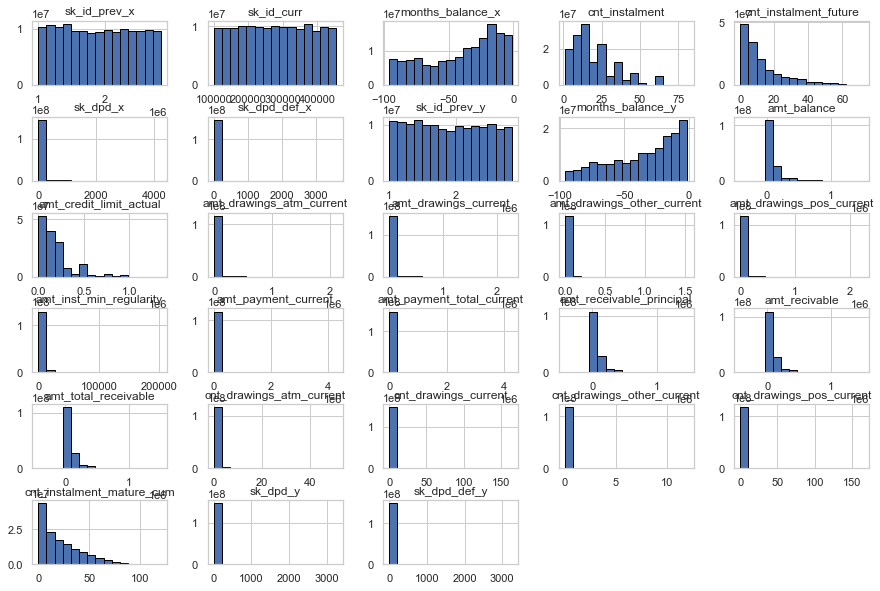

In [8]:
# Distribution of key numerical features
merged_data.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.subplots_adjust(hspace=0.5)

c:\Users\ABDERRAHMANE\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Future Installments Count in POS Cash Loans')

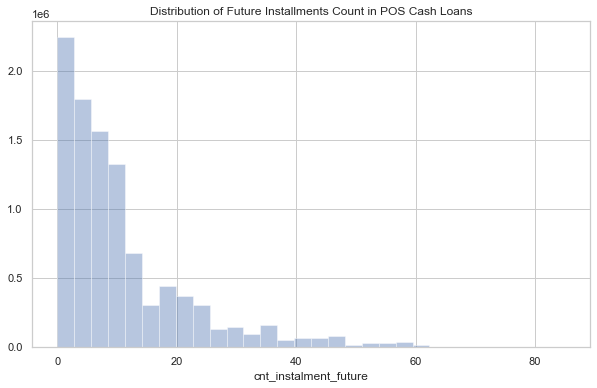

In [9]:
# Advanced Visualization: POS Cash Loan Amount Distribution
plt.figure(figsize=(10, 6))
sns.distplot(pos_cash_loans['cnt_instalment_future'], bins=30, kde=False)
plt.title('Distribution of Future Installments Count in POS Cash Loans')


In [11]:
# # Correlation analysis
# correlation_matrix = merged_data.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')

# Aggregation and Grouping

In [12]:
# Average balance by contract status in credit cards
avg_balance_by_status = credit_cards.groupby('name_contract_status')['amt_balance'].mean()

# Total POS cash loan count by contract status
total_pos_count_by_status = pos_cash_loans.groupby('name_contract_status').size().reset_index(name='count')

# Multi-level aggregation
# Average balance and total credit limit by contract status in credit cards
agg_data = credit_cards.groupby('name_contract_status').agg({'amt_balance': 'mean', 
                                                             'amt_credit_limit_actual': 'sum'}).reset_index()

# Visualization of Aggregated Data

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Active'),
  Text(1, 0, 'Approved'),
  Text(2, 0, 'Completed'),
  Text(3, 0, 'Demand'),
  Text(4, 0, 'Refused'),
  Text(5, 0, 'Sent proposal'),
  Text(6, 0, 'Signed')])

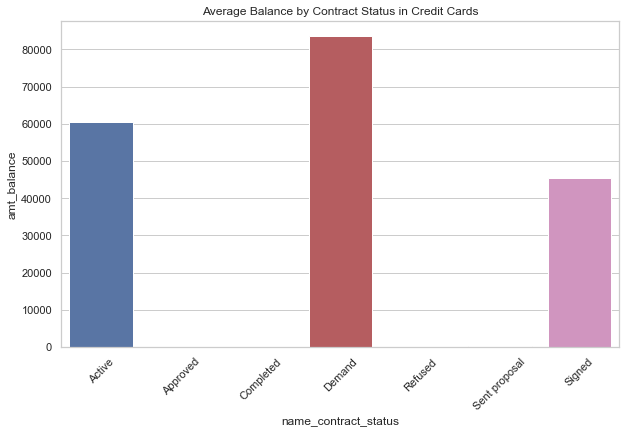

In [13]:
# Bar plot for average balance by contract status
plt.figure(figsize=(10, 6))
sns.barplot(x='name_contract_status', y='amt_balance', data=avg_balance_by_status.reset_index())
plt.title('Average Balance by Contract Status in Credit Cards')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Active'),
  Text(1, 0, 'Amortized debt'),
  Text(2, 0, 'Approved'),
  Text(3, 0, 'Canceled'),
  Text(4, 0, 'Completed'),
  Text(5, 0, 'Demand'),
  Text(6, 0, 'Returned to the store'),
  Text(7, 0, 'Signed'),
  Text(8, 0, 'XNA')])

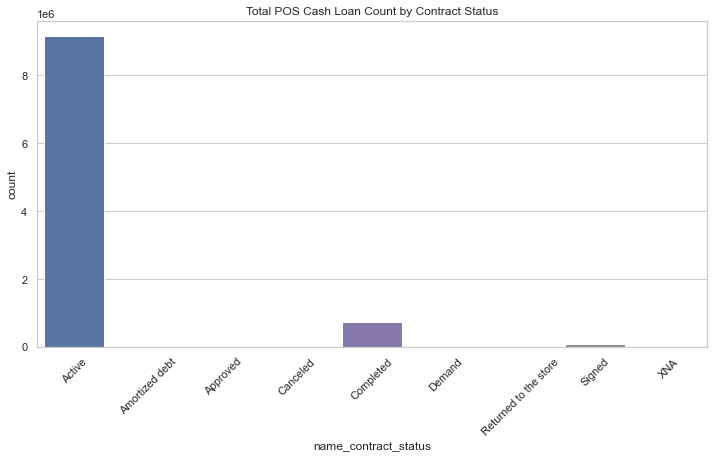

In [14]:
# Bar plot for total POS cash loan count by status
plt.figure(figsize=(12, 6))
sns.barplot(x='name_contract_status', y='count', data=total_pos_count_by_status)
plt.title('Total POS Cash Loan Count by Contract Status')
plt.xticks(rotation=45)

In [15]:
# outliers detections usgin z-score
credit_cards['balance_z_score'] = np.abs(stats.zscore(credit_cards['amt_balance']))
outliers = credit_cards[credit_cards['balance_z_score'] > 3]
outliers

,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,...,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def,balance_z_score
4,1891521,126868,-1,453919.46875,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.46875,0.0,1,0.0,1.0,101.0,Active,0,0,3.721479
19,1189095,231608,-4,452774.68750,450000,9000.0,9000.0,0.0,0.0,22916.474609,...,451429.18750,1.0,1,0.0,0.0,22.0,Active,0,0,3.710711
23,2021411,105755,-5,464452.46875,450000,135000.0,279112.5,137700.0,6412.5,8921.969727,...,456379.46875,5.0,7,1.0,1.0,25.0,Active,0,0,3.820560
37,2043751,441030,-4,436537.75000,450000,4500.0,4500.0,0.0,0.0,23238.585938,...,435192.25000,1.0,1,0.0,0.0,26.0,Active,0,0,3.557975
40,1974378,215299,-1,390808.31250,450000,0.0,0.0,0.0,0.0,20074.679688,...,390808.31250,0.0,0,0.0,0.0,21.0,Active,0,0,3.127810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840271,2775277,420343,-12,386595.31250,450000,0.0,0.0,0.0,0.0,19463.580078,...,383771.15625,0.0,0,0.0,0.0,18.0,Active,0,0,3.088180
3840275,2726719,310523,-12,761874.50000,765000,12600.0,12600.0,0.0,0.0,39625.695312,...,761874.50000,1.0,1,0.0,0.0,4.0,Active,0,0,6.618325
3840287,1050314,350128,-10,458892.12500,450000,31500.0,31500.0,0.0,0.0,31500.000000,...,456651.12500,2.0,2,0.0,0.0,54.0,Active,0,0,3.768256
3840288,1814640,309333,-15,458892.12500,450000,31500.0,31500.0,0.0,0.0,31500.000000,...,456651.12500,2.0,2,0.0,0.0,54.0,Active,0,0,3.768256
